# BANKS FINANCIAL REPORT ANALYZER
-----------------------------------------------

In [3]:
%matplotlib inline
import io
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Javascript, display, HTML, Markdown as md
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import json
import requests
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 100)

In [4]:
banks = {
        'DBS': {
                'ticker': 'D05',
                'morningstarID': '0P0000A67J'
        },
        'OCBC':  {
                'ticker': 'O39',
                'morningstarID': '0P0000A68H'
        },
        'UOB':{
                'ticker': 'U11',
                'morningstarID': '0P0000A692'
        }
}

# 1.DATA PREPARATION
-----------------------------------------------

### 1.1 START BY SELECTING A BANK

In [5]:
banksDropdown = widgets.Dropdown(options = sorted(banks.keys()))
bank = 'DBS'

def banksDropdownEventhandler(change):
    global bank 
    bank = change.new
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
banksDropdown.observe(banksDropdownEventhandler, names='value')

display(banksDropdown)


Dropdown(options=('DBS', 'OCBC', 'UOB'), value='DBS')

<IPython.core.display.Javascript object>

### 1.2 DOWNLOAD AND CLEAN UP FINANCIAL REPORT DATA


In [17]:
finUrl = 'https://api-global.morningstar.com/sal-service/v1/stock/newfinancials/{id}/{report}/detail?dataType=a&reportType=q&locale=en&&operation=export&clientId=MDC&benchmarkId=category&version=3.21.1'
finHeaders = {
    'Referer': 'https://www.morningstar.com/', 
    'apikey': 'lstzFDEOhfFNMLikKa0am9mgEKLBl49T', 
    'x-sal-contenttype': 'nNsGdN3REOnPMlKDShOYjlk6VYiEVLSdpfpXAm7o2Tk='
}

keyRatioUrl = 'http://financials.morningstar.com/finan/ajax/exportKR2CSV.html?&callback=?&t=XSES:{ticker}&region=sgp&culture=en-US&cur=&order=asc'
keyRatioHeaders = {
    'Referer': 'http://financials.morningstar.com/ratios/r.html?t=D05&region=sgp&culture=en-US'
}

def cleanData(df, roundDown = True):
     # Remove whitespaces
    df.index = df.index.str.strip()
    # Transpose df to make metrics as columns
    df = df.T
    # Remove commas and convert str to float for all cols
    df[df.keys()] = df[df.keys()].replace({',': ''}, regex=True).astype(float)
    df = df/1000000 if roundDown else df
    # Reorder the rows to be ascending downwards
    df = df.sort_index()
    return df

def cleanKeyRatios(df):
    df = df.fillna(0)
    # Get names of indexes for which column '2010-12 has value '2010-12' or empty rows
    indexNames = df[(df['2010-12'] == '2010-12') | (
                    (df['2011-12'] == 0) &
                    (df['2012-12'] == 0) &
                    (df['2013-12'] == 0) &
                    (df['2014-12'] == 0) &
                    (df['2015-12'] == 0) &
                    (df['2016-12'] == 0) &
                    (df['2017-12'] == 0) &
                    (df['2018-12'] == 0) &
                    (df['2019-12'] == 0) &
                    (df['TTM'] == 0) 
                    )].index
    # Drop row reference by the indexes
    df = df.drop(indexNames , inplace=False)
    # Rename column name to match the reports data
    df = df.rename(columns={'2010-12': '2010',
                       '2011-12': '2011',
                       '2012-12': '2012',
                       '2013-12': '2013',
                       '2014-12': '2014',
                       '2015-12': '2015',
                       '2016-12': '2016',
                       '2017-12': '2017',
                       '2018-12': '2018',
                       '2019-12': '2019',
                       'TTM': 'TTM/Latest Quarter',
                      })
    
    return cleanData(df, False)
    


# Download finacial reports 
reports = {
    'balancesheet': None,
    'incomestatement': None,
    'cashflow': None,
}

for types in reports.keys():
    print('Downloading % s'%types)
    response = requests.get(finUrl.format(id = banks[bank]['morningstarID'], report = types), headers=finHeaders)
    with io.BytesIO(response.content) as fh:
        reports[types] = cleanData(pd.io.excel.read_excel(fh, index_col=0))
    print('Done')

        
# Download key ratio data
print('Downloading Key Ratios data')
with open('keyratios.csv', 'wb') as f:
    response = requests.get(keyRatioUrl.format(ticker = banks[bank]['ticker']), headers=keyRatioHeaders)
    f.write(response.content)

keyratios = pd.read_csv('keyratios.csv', index_col=0, skiprows=2, header=0, na_values = '', skip_blank_lines=False )
keyratios = cleanKeyRatios(keyratios)
keyratios.to_csv('clean_keyratios.csv')

print('Done')


Done
Done
Done
Done


# 2. VALIDATE DATA

### 2.1 SELECT A REPORT TYPE TO VIEW ITS DATA

In [18]:
reportsDropdown = widgets.Dropdown(options = sorted(reports.keys()))
chosenReport = 'balancesheet'

def reportsDropdownEventhandler(change):
    global chosenReport 
    chosenReport = change.new
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+3)'))
    
reportsDropdown.observe(reportsDropdownEventhandler, names='value')

display(reportsDropdown)

Dropdown(options=('balancesheet', 'cashflow', 'incomestatement'), value='balancesheet')

<IPython.core.display.Javascript object>

In [28]:
md("### 2.2 {report} OF {bank}".format(report=chosenReport.upper() , bank=bank))

### 2.2 CASHFLOW OF UOB

In [29]:
reports[chosenReport]

Name,"Cash Flow from Operating Activities, Indirect","Net Cash Flow from Continuing Operating Activities, Indirect",Cash Generated from Operating Activities,Income/Loss before Non-Cash Adjustment,Total Adjustments for Non-Cash Items,"Depreciation, Amortization and Depletion, Non-Cash Adjustment","Depreciation and Amortization, Non-Cash Adjustment","Depreciation, Non-Cash Adjustment","Stock-Based Compensation, Non-Cash Adjustment","Taxes, Non-Cash Adjustment",Provision and Impairment for Loan Losses and Credit Risk,"Net Investment Income/Loss, Non-Cash Adjustment","Share of Profit/Loss from Associates, Joint Ventures and other Equity Investments, Non-Cash Adjustment","Irregular Income/Loss, Non-Cash Adjustment","Gain/Loss on Disposals, Non-Cash Adjustment","Gain/Loss on Disposal/Sale of Other Assets, Non-Cash Adjustment",Changes in Operating Capital,Change in Cash and Balances at Central Banks,Change in Deposits,Change in Loans and Advances,Change in Financial Assets,Change in Payables and Accrued Expenses,Change in Trade and Other Payables,Change in Trade Notes Payable,Change in Other Payables,Change in Other Assets,Change in Other Liabilities,"Taxes Refund/Paid, Indirect",Other Operating Cash Flow,Cash Flow from Investing Activities,Cash Flow from Continuing Investing Activities,"Purchase/Sale and Disposal of Property, Plant and Equipment, Net","Purchase of Property, Plant and Equipment","Sale and Disposal of Property, Plant and Equipment",Purchase/Sale of Equity Investments,Purchase of Joint Venture/Associate,Sale of Joint Venture/Associate,"Dividends Received/Paid, CFI",Other Investing Cash Flow,"Purchase/Sale of Business, Net",Purchase/Acquisition of Business,Sale of Business,Cash Flow from Financing Activities,Cash Flow from Continuing Financing Activities,"Issuance of/Payments for Common Stock, Net",Payments for Common Stock,"Issuance of/Repayments for Debt, Net","Issuance of/Repayments for Long Term Debt, Net",Proceeds from Issuance of Long Term Debt,Repayments for Long Term Debt,Issuance of/Repayments for Lease Financing,Repayments for Lease Financing,Net Movement in Non-Controlling/Minority Interest,Cash Dividends and Interest Paid,Cash Dividends Paid,Common Stock Dividends Paid,Preferred Stock Dividends Paid,Cash Dividends Paid to Non-Controlling/Minority Interests,Other Financing Cash Flow,"Issuance of/Payments for Preferred Stock, Net",Payments for Preferred Stock,"Cash and Cash Equivalents, End of Period",Change in Cash,Effect of Exchange Rate Changes,"Cash and Cash Equivalents, Beginning of Period",Other Changes,"Change in Cash As Reported, Supplemental",Total Net Change in Cash,Fiscal year ends in Dec 31 | SGD
2010,10407.348,10407.348,7353.174,nan,-204.814,137.067,137.067,137.067,19.219,nan,nan,nan,nan,-361.100,-361.100,nan,7557.988,-1279.238,25563.648,-13612.706,-3224.059,-149.125,-149.125,nan,-149.125,-459.419,718.887,-488.291,3542.465,488.678,488.678,-86.747,-106.027,19.280,-1.674,-1.674,nan,91.532,-2.128,487.695,-1.068,488.763,-181.401,-181.401,0.000,nan,219.237,nan,nan,nan,nan,nan,nan,-392.903,-392.903,-286.886,-106.017,-7.727,-0.008,nan,nan,27142.636,10714.625,-116.071,16544.082,nan,10598.554,10598.554,nan
2011,-9559.470,-9559.470,-12206.892,nan,162.586,115.628,115.628,115.628,30.983,nan,nan,nan,nan,15.975,15.975,nan,-12369.478,-790.552,9738.067,-29148.735,7634.461,441.453,441.453,nan,441.453,-928.410,684.238,-601.036,3248.458,-16.620,-16.620,-127.027,-187.117,60.090,-14.764,-14.830,0.066,125.171,nan,0.000,nan,nan,4862.410,4862.410,-8.827,-8.827,5522.832,5522.832,6822.832,-1300.000,nan,nan,nan,-642.850,-642.850,-539.134,-103.716,-7.434,-1.311,nan,nan,22395.756,-4713.680,-33.200,27142.636,nan,-4746.880,-4746.880,nan
2012,6340.049,6340.049,6932.871,3747.571,-387.130,121.493,121.493,121.493,21.646,nan,nan,nan,nan,-530.269,-530.269,-530.269,3572.430,-372.700,17135.097,-12192.248,-293.135,-158.106,-158.106,-158.106,0.000,779.412,-1325.890,-592.822,nan,-67.798,-67.798,-160.711,-220.520,59.809,-0.043,-0.043,0.000

# 3. ANALYSE DATA

### 3.1 REVENUE VS NET INCOME 

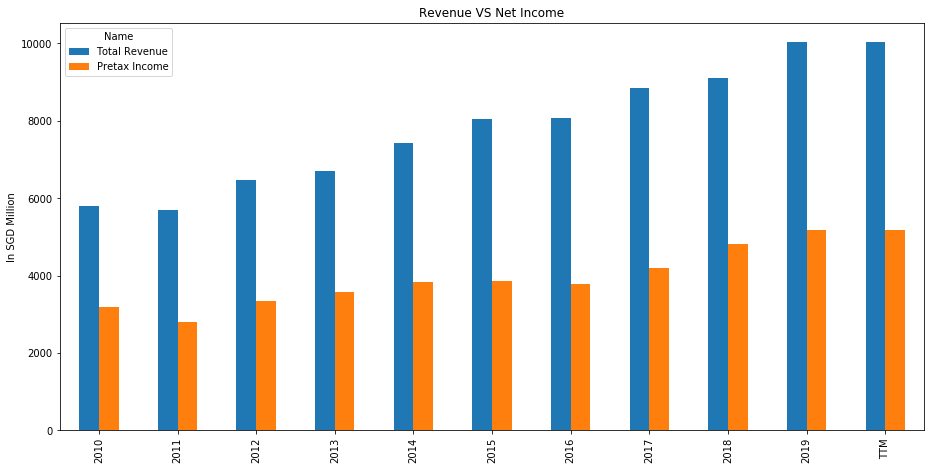

In [21]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

reports["incomestatement"][['Total Revenue', 'Pretax Income']].plot.bar(ax=axs)
axs.set_title('Revenue VS Net Income');
axs.set_ylabel("In SGD Million");

## 3.2 OPERATING LEVERAGE AND EFFICIENCY RATIO FOR BANKS


Efficiency ratio: Operating Expenses / Total Revenue

Note that Operating Expenses does not include Interest Expenses, as the latter is naturally occurring when the deposits within a bank grow. However, Non-Interest Expenses, such as marketing or operational expenses, can be controlled by the bank. 
A bank efficiency ratio measures a bank's overhead as a percentage of its revenue. A lower efficiency ratio means that a bank is operating better. 

An efficiency ratio of 50% or under is considered optimal. If the efficiency ratio increases, it means a bank's expenses are increasing or its revenues are decreasing.


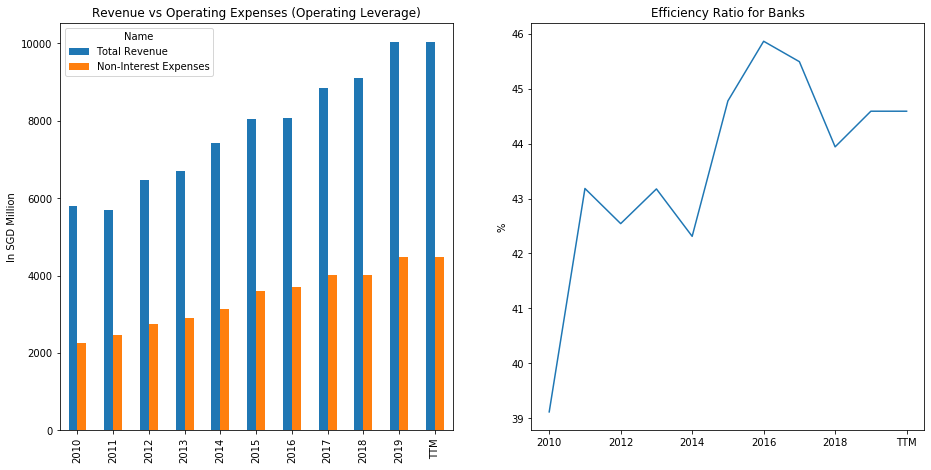

In [22]:
effiencyRatio = (reports["incomestatement"]['Non-Interest Expenses'].abs()/reports["incomestatement"]['Total Revenue'])*100
                                                                                                 
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15.5, 7.5)

reports["incomestatement"][['Total Revenue', 'Non-Interest Expenses']].abs().plot.bar(ax=axs[0])
axs[0].set_title('Revenue vs Operating Expenses (Operating Leverage)');
axs[0].set_ylabel("In SGD Million");

effiencyRatio.plot()
axs[1].set_title('Efficiency Ratio for Banks');
axs[1].set_ylabel("%");                                                                                                 

### 3.3 NET INTEREST MARGIN

( Investment Return - Interest Expenses ) / ( Average Earning Assets )

The equivalent of gross margin to conventional company. Note there is no COGS for banks so there is no gross margin.
Net interest margin (NIM) is a measurement comparing the net interest income a financial firm generates from credit products like loans and mortgages, with the outgoing interest it pays holders of savings accounts and certificates of deposit (CDs). 

Simply put: a positive net interest margin suggests that an entity operates profitably, while a negative figure implies investment inefficiency.


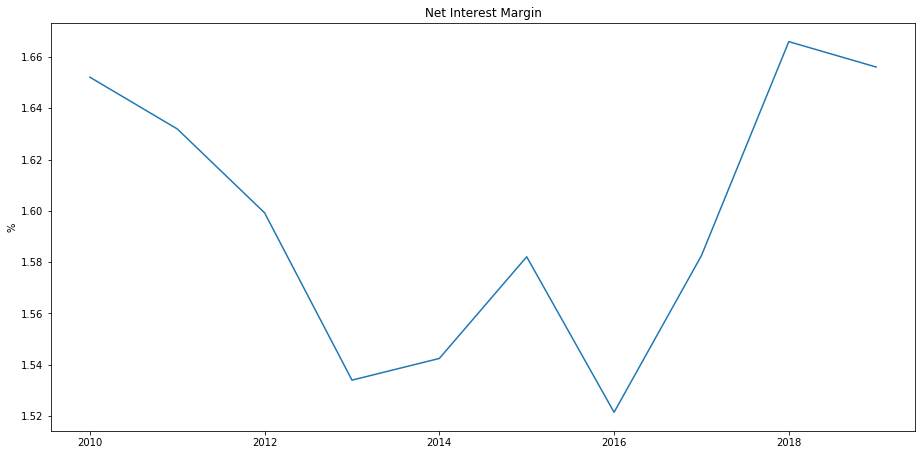

In [23]:
assets = reports['balancesheet']['Total Assets']
assets.head(10)
avgAssets = pd.Series([], dtype='float64')

for i in range(assets.shape[0]):
    if i == 0: 
        avgAssets[assets.index[i]] = (assets[i] + assets[0])/2 
    else: 
        avgAssets[assets.index[i]] = (assets[i] + assets[i-1])/2
netInteretMargin = (reports['incomestatement']['Net Interest Income'] / avgAssets) * 100

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

netInteretMargin.plot()
axs.set_title('Net Interest Margin');
axs.set_ylabel("%");  

### 3.4 DEBT-TO-EQUITY (D/E) RATIO

( Total Liabilities ) / ( Total Shareholders’ Equity )

(D/E) ratio is more often referred to as Liabilities to Equity ratio. Note that Liabilities includes accounts payable, negative goodwill and "other" as well.

A high debt/equity ratio generally indicates that a company has been aggressive in financing its growth with debt. This can result in volatile earnings as a result of the additional interest expense. If the company's interest expense grows too high, it may increase the company's chances of a default or bankruptcy.

It is better to compare with historical performance and industry counterparts.


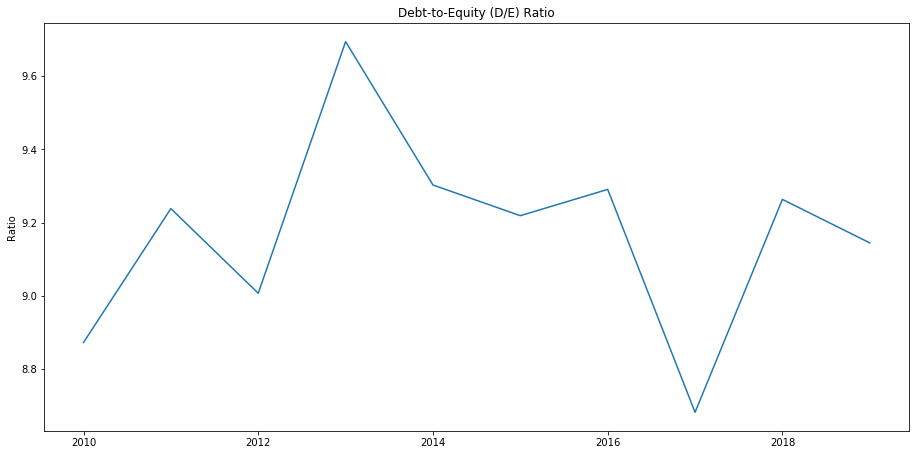

In [24]:
debtToEquity = reports['balancesheet']['Total Liabilities'] / reports['balancesheet']['Total Equity']

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

debtToEquity.plot()
axs.set_title('Debt-to-Equity (D/E) Ratio');
axs.set_ylabel("Ratio");  

### 3.5 DEBT-TO-ASSET RATIO

( Total Debt ) / ( Total Assets ) =  ( Total Debt ) / ( Total Liabilities + Total Shareholders’ Equity )

In the case of the debt ratio, financial data providers calculate it using only long-term and short-term debt (including current portions of long-term debt and deposits), excluding liabilities such as accounts payable, negative goodwill and "other."
A debt ratio greater than 1.0 (unbalanced balance sheet?) tells you that a company has more debt than assets. Meanwhile, a debt ratio less than 100% indicates that a company has more assets than debt.


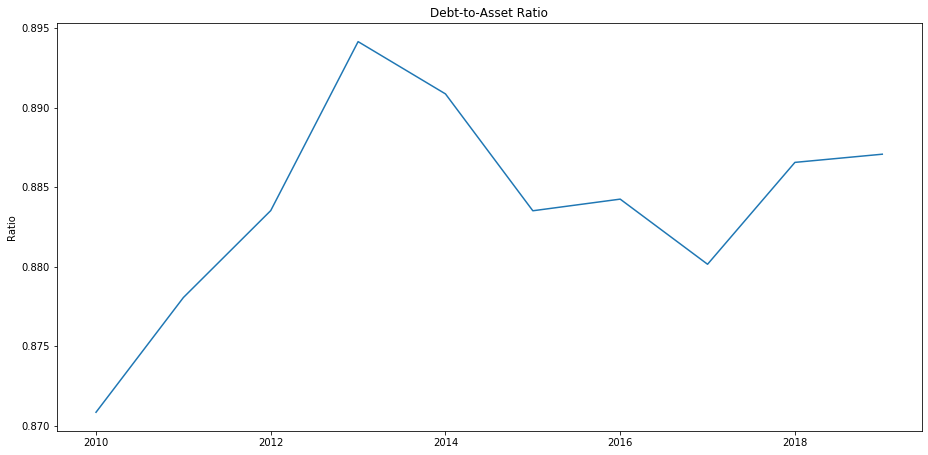

In [25]:
debtToAsset = (reports['balancesheet']['Total Deposits'] + reports['balancesheet']['Trading and Financial Liabilities']) / reports['balancesheet']['Total Assets']

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

debtToAsset.plot()
axs.set_title('Debt-to-Asset Ratio');
axs.set_ylabel("Ratio");  

### 3.6 DEBT-TO-CAPITAL RATIO

( Total interest bearing debt ) / ( Total interest bearing debt+Total Shareholder Equity )

Capital = Total interest-bearing debt + Total Shareholder Equity which is < Total Assets. The higher the debt-to-capital ratio, the riskier the company.  


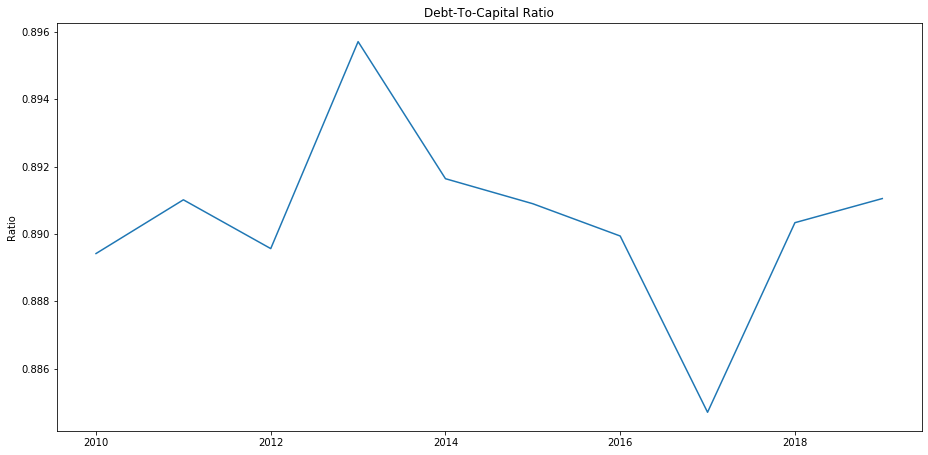

In [26]:
debtToCapital = reports['balancesheet']['Total Deposits'] / (reports['balancesheet']['Total Deposits'] + reports['balancesheet']['Total Equity'])

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(15.5, 7.5)

debtToCapital.plot()
axs.set_title('Debt-To-Capital Ratio');
axs.set_ylabel("Ratio");  

In [27]:
keyratios

,Revenue SGD Mil,Net Income SGD Mil,Earnings Per Share SGD,Dividends SGD,Payout Ratio % *,Shares Mil,Book Value Per Share * SGD,Operating Cash Flow SGD Mil,Cap Spending SGD Mil,Free Cash Flow SGD Mil,Free Cash Flow Per Share * SGD,Revenue,SG&A,Other,Net Int Inc & Other,EBT Margin,Tax Rate %,Net Margin %,Asset Turnover (Average),Return on Assets %,Financial Leverage (Average),Return on Equity %,Operating Cash Flow Growth % YOY,Cap Ex as a % of Sales,Free Cash Flow/Sales %,Free Cash Flow/Net Income,Cash & Short-Term Investments,Accounts Receivable,Other Current Assets,Net PP&E,Intangibles,Other Long-Term Assets,Total Assets,Accounts Payable,Taxes Payable,Other Short-Term Liabilities,Total Liabilities,Total Stockholders' Equity,Total Liabilities & Equity,Financial Leverage,Debt/Equity,Fixed Assets Turnover,Asset Turnover
2010,5800.000,2696.000,1.690,0.600,35.500,1528.000,13.920,10407.000,-106.000,10301.000,6.740,100.000,15.020,24.090,55.110,55.110,15.000,44.650,0.030,1.300,9.960,12.800,44.830,1.830,177.600,3.820,18.050,0.000,-18.050,0.480,1.970,-2.450,100.000,0.600,0.330,-0.930,89.950,10.050,100.000,9.960,0.290,5.630,0.030
2011,5699.000,2327.000,1.420,0.600,39.600,1564.000,14.160,-9559.000,-187.000,-9747.000,-2.740,100.000,15.820,27.360,49.270,49.270,16.640,39.020,0.030,0.990,10.320,10.010,0.000,3.280,-171.030,-4.190,16.600,0.000,-16.600,0.440,1.770,-2.210,100.000,0.730,0.260,-0.990,90.300,9.700,100.000,10.320,0.510,5.510,0.030
2012,6475.000,2803.000,1.710,0.600,35.100,1578.000,14.560,6340.000,-221.000,6120.000,3.880,100.000,2.630,39.910,51.750,51.750,15.840,41.700,0.030,1.100,11.030,11.770,0.000,3.410,94.510,2.180,16.820,0.880,-17.700,0.490,1.650,-2.140,100.000,0.210,0.230,-0.440,90.080,9.920,100.000,11.030,0.630,5.670,0.030
2013,6713.000,3008.000,1.840,0.600,32.900,1580.000,15.970,-11695.000,-221.000,-11916.000,-3.480,100.000,2.380,40.790,53.390,53.390,15.600,43.270,0.030,1.080,11.120,11.980,0.000,3.300,-177.520,-3.960,18.100,0.810,-18.900,0.460,1.460,-1.920,100.000,0.190,0.170,-0.360,90.710,9.290,100.000,11.120,0.780,5.280,0.030
2014,7436.000,3249.000,1.970,0.700,34.400,1597.000,17.850,7111.000,-259.000,6852.000,0.330,100.000,2.680,39.630,51.440,51.440,14.660,42.320,0.030,1.070,10.670,11.590,0.000,3.480,92.150,2.110,19.040,0.510,-19.550,0.470,1.350,-1.820,100.000,0.180,0.120,-0.300,90.350,9.650,100.000,10.670,0.760,5.430,0.030
2015,8033.000,3209.000,1.930,0.850,44.500,1607.000,18.850,661.000,-692.000,-31.000,10.040,100.000,3.010,41.760,48.160,48.160,16.770,38.630,0.030,1.000,10.560,10.580,-90.700,8.610,-0.380,-0.010,17.680,1.240,-18.920,0.550,1.310,-1.860,100.000,0.220,0.140,-0.360,90.260,9.740,100.000,10.560,0.690,5.070,0.030
2016,8060.000,3096.000,1.850,0.700,37.200,1623.000,19.820,-13313.000,-383.000,-13696.000,-10.870,100.000,3.550,42.310,46.860,46.860,17.710,37.270,0.020,0.920,10.340,9.560,0.000,4.750,-169.930,-4.420,17.180,1.140,-18.320,0.550,1.220,-1.780,100.000,0.250,0.120,-0.370,90.330,9.670,100.000,10.340,0.810,4.450,0.020
2017,8853.000,3390.000,1.980,0.700,37.400,1657.000,20.840,3909.000,-349.000,3560.000,-4.160,100.000,4.130,41.370,47.520,47.520,19.020,37.140,0.030,0.940,9.730,9.430,0.000,3.950,40.210,1.050,20.400,0.840,-21.240,0.550,1.160,-1.700,100.000,0.200,0.150,-0.360,89.720,10.280,100.000,9.730,0.700,4.590,0.030
2018,9111.000,4008.000,2.330,0.950,41.100,1671.000,22.070,-3707.000,-516.000,-4224.000,2.130,100.000,4.550,39.390,52.970,52.970,16.690,42.770,0.020,1.040,10.320,10.470,0.000,5.670,-46.360,-1.050,18.140,0.700,-18.840,0.580,1.070,-1.650,100.000,0.230,0.130,-0.360,90.300,9.700,100.000,10.320,0.830,4.300,0.020
2019,10030.000,4343.000,2.540,1.050,41.500,1673.000,23.670,8333.000,-573.000,7760.000,-3.050,100.000,5.030,39.560,51.590,51.590,15.700,42.330,0.030,1.070,10.200,10.990,0.000,5.710,77.370,1.790,18.060,0.670,-18.720,0.680,1.030,-1.710,100.000,0.240,0.120,-0.360,90.190,9.810,100.000,10.200,0.660,3.990,0.030
